In [20]:
import pandas as pd
import numpy as np
import json
import glob
import pandas as pd
import csv

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy
import spacy
from nltk.corpus import stopwords


In [21]:
# Bag of words for each category to classify text

# topics = {"fee": ["fee", "money", "price", "cost", "expensive", "cost", "charge"],
#         "transaction": ["deposit", "withdraw", "bank", "delay", "debit", "credit", "card"],
#         "trust": ["company", "scam"],
#         "service": ["service", "customer", "contact", "support", "email"],
#         "app": ["interface", "easy", "friendly", "clean", "user"]}

topics = {"fee": ["fee", "money", "price", "cost", "expensive", "cost", "charge"],
        "transaction": ["deposit", "withdraw", "bank", "delay", "debit", "credit", "card"],
        "trust": ["company", "scam", "fraud", "theft"], 
        "service": ["service", "customer", "contact", "support", "email"],
        "app": ["interface", "easy", "clean", "user" ,"issue", "bug", "glitch", "ui"],
        "verification": ["registration", "verification", "document", "license", "photo", "identification"]}

        # Could use TFIDF to get keywords

In [22]:
# Pre-processing the document
all_files = ["robinhood.csv", "webull.csv", "etoro.csv"]

# Combine all the csv files into one
li = []
for filename in all_files:
    df = pd.read_csv(filename)
    li.append(df)

# Get only rows with >50 chars or about 10 words
def get_rows(row):
    row["review_len"] = len(row["content"]) if type(row["content"]) == str else 0
    return row;
       
frame = pd.concat(li, axis=0, ignore_index=True)
frame = frame.loc[:, ["reviewId", "content", "score", "at"]]
frame = frame.apply(get_rows, axis=1)
frame = frame.loc[frame["review_len"] > 50]
frame



,reviewId,content,score,at,review_len
2,748c2355-d884-463b-8c9a-46d9e8cfa1ea,"I once wrote my reviews here, how robinhood ha...",1,2022-07-01 11:01:46,496
3,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,"Buy stock, market updates. If you know exactly...",5,2022-07-01 10:51:17,408
7,7444c5dc-8395-4890-9c47-5f690fb6f69b,Good app Very bad horrible email customer supp...,1,2022-07-01 09:55:46,441
8,38b8059c-47bd-4998-9d56-fecf18663cc6,It's like........the first time I fell in love...,5,2022-07-01 09:30:57,155
10,3ced6d9c-be58-4213-bdf3-ec12a750c288,Rep keep hanging on me instead of helping. Aft...,1,2022-07-01 09:12:50,452
...,...,...,...,...,...
14992,b28ce657-a318-454e-abd7-06d6db719655,apps is easy good enjoy my apps 🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰...,5,2021-05-30 11:19:26,69
14993,bdaa0b97-d095-4a04-8e5a-3b68a40d0c22,this app is very good I became a multi billion...,5,2021-05-30 10:13:56,304
14994,35bc4a50-a347-44d8-bdcb-0e259b024e5b,Good apps for investment but it's lack evertin...,4,2021-05-30 10:01:12,91
14995,dd441a32-1fc6-47a9-b5de-adaa7901f1fa,Great way to be conned by Toro Telemarketing i...,1,2021-05-30 09:03:27,308


In [23]:
# Break each review into sentences
sentenced_reviews = {"reviewId": [], "content": [], "score": [], "at" : [], "review_len": [], "sentence_len": []}
frame["sentences"] = frame["content"].str.split(".");

for index, row in frame.iterrows():    
    for sentence in row["sentences"]:
        sentenced_reviews["content"].append(sentence)
        sentenced_reviews["reviewId"].append(row["reviewId"])
        sentenced_reviews["score"].append(row["score"])
        sentenced_reviews["review_len"].append(row["review_len"])
        sentenced_reviews["at"].append(row["at"])
        sentenced_reviews["sentence_len"].append(len(sentence))

frame = pd.DataFrame(sentenced_reviews)
frame = frame.loc[(frame["content"].str.len() > 20)] # Only get sentences longer than about 5 words

In [24]:
# Process documents and insert to df

spacy.load
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
allowed_postags=["NOUN", "ADJ"]
stop_words=stopwords.words("english")
def insert_processed_doc(row):

    # Lemmatization
    text = row["content"]
    doc = nlp(text) # Create document from the raw text/string
    new_text = []
    for token in doc:
        if token.pos_ in allowed_postags and token.pos_ not in stop_words:
            new_text.append(token.lemma_) # Appends only lemma to new_text
    lemma = " ".join(new_text)
 
    # Remove marks and make everything lowercase
    final_doc = gensim.utils.simple_preprocess(lemma, deacc=True);

    row["content_proc"] = final_doc
    return row

frame = frame.apply(insert_processed_doc, axis=1)

frame


,reviewId,content,score,at,review_len,sentence_len,content_proc
0,748c2355-d884-463b-8c9a-46d9e8cfa1ea,"I once wrote my reviews here, how robinhood ha...",1,2022-07-01 11:01:46,496,495,"[review, robinhood, fund, account, easy, money..."
2,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,"Buy stock, market updates",5,2022-07-01 10:51:17,408,25,"[stock, market, update]"
3,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,"If you know exactly what you want to buy, you...",5,2022-07-01 10:51:17,408,108,[format]
4,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,But if you aren't the best at keeping up with...,5,2022-07-01 10:51:17,408,150,"[good, current, event, platform, company]"
5,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,You even get a weekly newsletter that recaps ...,5,2022-07-01 10:51:17,408,121,"[weekly, newsletter, important, market, event]"
...,...,...,...,...,...,...,...
27942,35bc4a50-a347-44d8-bdcb-0e259b024e5b,Please solve this problem,4,2021-05-30 10:01:12,91,26,[problem]
27943,dd441a32-1fc6-47a9-b5de-adaa7901f1fa,Great way to be conned by Toro Telemarketing i...,1,2021-05-30 09:03:27,308,100,"[great, way, commie, building]"
27947,dd441a32-1fc6-47a9-b5de-adaa7901f1fa,Eugen Sima fled country when he as portfolio m...,1,2021-05-30 09:03:27,308,99,"[country, portfolio, manager, lost, transactio..."
27948,dd441a32-1fc6-47a9-b5de-adaa7901f1fa,That is how you are duped with others togethe...,1,2021-05-30 09:03:27,308,101,"[other, social, medium, pyramid, scheme, tradi..."


In [25]:
# Returns the topic which the processed_doc contains the most words from
def get_topic(topics, processed_doc):
    topic_scores = dict.fromkeys(topics, 0)
    for word in processed_doc:
        for topic in topics.keys():
            if word in topics[topic]: topic_scores[topic] += 1
    topic_max = max(topic_scores, key=topic_scores.get)  
    if topic_scores[topic_max] == 0: topic_max = "N"     
    return (topic_max, topic_scores[topic_max] if topic_max != "N" else 0)

In [26]:
frame

,reviewId,content,score,at,review_len,sentence_len,content_proc
0,748c2355-d884-463b-8c9a-46d9e8cfa1ea,"I once wrote my reviews here, how robinhood ha...",1,2022-07-01 11:01:46,496,495,"[review, robinhood, fund, account, easy, money..."
2,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,"Buy stock, market updates",5,2022-07-01 10:51:17,408,25,"[stock, market, update]"
3,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,"If you know exactly what you want to buy, you...",5,2022-07-01 10:51:17,408,108,[format]
4,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,But if you aren't the best at keeping up with...,5,2022-07-01 10:51:17,408,150,"[good, current, event, platform, company]"
5,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,You even get a weekly newsletter that recaps ...,5,2022-07-01 10:51:17,408,121,"[weekly, newsletter, important, market, event]"
...,...,...,...,...,...,...,...
27942,35bc4a50-a347-44d8-bdcb-0e259b024e5b,Please solve this problem,4,2021-05-30 10:01:12,91,26,[problem]
27943,dd441a32-1fc6-47a9-b5de-adaa7901f1fa,Great way to be conned by Toro Telemarketing i...,1,2021-05-30 09:03:27,308,100,"[great, way, commie, building]"
27947,dd441a32-1fc6-47a9-b5de-adaa7901f1fa,Eugen Sima fled country when he as portfolio m...,1,2021-05-30 09:03:27,308,99,"[country, portfolio, manager, lost, transactio..."
27948,dd441a32-1fc6-47a9-b5de-adaa7901f1fa,That is how you are duped with others togethe...,1,2021-05-30 09:03:27,308,101,"[other, social, medium, pyramid, scheme, tradi..."


In [27]:
def insert_topic(row):
    topic_max, topic_score = get_topic(topics, row["content_proc"])
    row["topic"] = topic_max
    row["topic_score"] = topic_score
    return row

frame = frame.apply(insert_topic, axis=1)

In [28]:
frame.loc[frame["topic"] != "N"]

,reviewId,content,score,at,review_len,sentence_len,content_proc,topic,topic_score
0,748c2355-d884-463b-8c9a-46d9e8cfa1ea,"I once wrote my reviews here, how robinhood ha...",1,2022-07-01 11:01:46,496,495,"[review, robinhood, fund, account, easy, money...",fee,3
4,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,But if you aren't the best at keeping up with...,5,2022-07-01 10:51:17,408,150,"[good, current, event, platform, company]",trust,1
7,7444c5dc-8395-4890-9c47-5f690fb6f69b,Good app Very bad horrible email customer supp...,1,2022-07-01 09:55:46,441,133,"[good, app, bad, horrible, email, customer, su...",service,4
10,7444c5dc-8395-4890-9c47-5f690fb6f69b,Extra verification delete my info please! Don...,1,2022-07-01 09:55:46,441,215,"[extra, verification, delete, info, date, rep,...",trust,1
31,3ced6d9c-be58-4213-bdf3-ec12a750c288,After i verified myself etc n told her my iss...,1,2022-07-01 09:12:50,452,81,[issue],app,1
...,...,...,...,...,...,...,...,...,...
27928,3f2b7de9-8745-48de-a047-08555ae5d99a,"No sign up bonus, you guys need to put your cu...",1,2021-05-31 03:13:02,189,76,"[sign, bonus, guy, customer]",service,1
27929,3f2b7de9-8745-48de-a047-08555ae5d99a,Plus read a bunch of horror stories on reddit...,1,2021-05-31 03:13:02,189,111,"[bunch, horror, story, reddit, withdrawal, pro...",service,1
27937,b28ce657-a318-454e-abd7-06d6db719655,apps is easy good enjoy my apps 🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰🥰...,5,2021-05-30 11:19:26,69,69,"[app, easy, good, app]",app,1
27941,35bc4a50-a347-44d8-bdcb-0e259b024e5b,Good apps for investment but it's lack evertin...,4,2021-05-30 10:01:12,91,64,"[good, app, investment, lack, evertine, deposit]",transaction,1


In [29]:
frame["topic"].value_counts()

N               12495
fee              1930
app              1872
service           864
transaction       555
trust             323
verification      131
Name: topic, dtype: int64

In [30]:
# Make predictions on sentiment
from textblob import TextBlob

def add_sentiment_cols(row):
    sent_obj = TextBlob(row["content"])
    row["sent_pol"] = sent_obj.sentiment.polarity
    row["sent_sub"] = sent_obj.sentiment.subjectivity
    return row;

frame = frame.apply(add_sentiment_cols, axis="columns")
frame

,reviewId,content,score,at,review_len,sentence_len,content_proc,topic,topic_score,sent_pol,sent_sub
0,748c2355-d884-463b-8c9a-46d9e8cfa1ea,"I once wrote my reviews here, how robinhood ha...",1,2022-07-01 11:01:46,496,495,"[review, robinhood, fund, account, easy, money...",fee,3,0.369333,0.671111
2,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,"Buy stock, market updates",5,2022-07-01 10:51:17,408,25,"[stock, market, update]",N,0,0.000000,0.000000
3,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,"If you know exactly what you want to buy, you...",5,2022-07-01 10:51:17,408,108,[format],N,0,0.267857,0.392857
4,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,But if you aren't the best at keeping up with...,5,2022-07-01 10:51:17,408,150,"[good, current, event, platform, company]",trust,1,0.500000,0.350000
5,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,You even get a weekly newsletter that recaps ...,5,2022-07-01 10:51:17,408,121,"[weekly, newsletter, important, market, event]",N,0,-0.022685,0.658796
...,...,...,...,...,...,...,...,...,...,...,...
27942,35bc4a50-a347-44d8-bdcb-0e259b024e5b,Please solve this problem,4,2021-05-30 10:01:12,91,26,[problem],N,0,0.000000,0.000000
27943,dd441a32-1fc6-47a9-b5de-adaa7901f1fa,Great way to be conned by Toro Telemarketing i...,1,2021-05-30 09:03:27,308,100,"[great, way, commie, building]",N,0,0.800000,0.750000
27947,dd441a32-1fc6-47a9-b5de-adaa7901f1fa,Eugen Sima fled country when he as portfolio m...,1,2021-05-30 09:03:27,308,99,"[country, portfolio, manager, lost, transactio...",fee,1,0.000000,0.000000
27948,dd441a32-1fc6-47a9-b5de-adaa7901f1fa,That is how you are duped with others togethe...,1,2021-05-30 09:03:27,308,101,"[other, social, medium, pyramid, scheme, tradi...",N,0,0.065104,0.066667


In [31]:
# Create new DF to store whether sentiment is positive
sentiment_df = frame.copy()
sentiment_df.reset_index(inplace=True)
sentiment_df.drop(columns="index", inplace=True)
sentiment_df["is_positive"] = sentiment_df["sent_pol"] > 0
sentiment_df.head(100)

,reviewId,content,score,at,review_len,sentence_len,content_proc,topic,topic_score,sent_pol,sent_sub,is_positive
0,748c2355-d884-463b-8c9a-46d9e8cfa1ea,"I once wrote my reviews here, how robinhood ha...",1,2022-07-01 11:01:46,496,495,"[review, robinhood, fund, account, easy, money...",fee,3,0.369333,0.671111,True
1,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,"Buy stock, market updates",5,2022-07-01 10:51:17,408,25,"[stock, market, update]",N,0,0.000000,0.000000,False
2,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,"If you know exactly what you want to buy, you...",5,2022-07-01 10:51:17,408,108,[format],N,0,0.267857,0.392857,True
3,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,But if you aren't the best at keeping up with...,5,2022-07-01 10:51:17,408,150,"[good, current, event, platform, company]",trust,1,0.500000,0.350000,True
4,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,You even get a weekly newsletter that recaps ...,5,2022-07-01 10:51:17,408,121,"[weekly, newsletter, important, market, event]",N,0,-0.022685,0.658796,False
...,...,...,...,...,...,...,...,...,...,...,...,...
95,c8a3b8b3-b8af-4360-8d56-76acfb57f6ea,The format makes it easy to view the purchase...,5,2022-06-29 13:49:14,233,199,"[format, easy, purchase, current, value, stock...",app,1,0.108333,0.391667,True
96,43e8fd81-f74d-4148-beac-f70a3954b674,Early Direct Deposit is a joke,1,2022-06-29 13:21:29,499,30,"[early, joke]",N,0,0.100000,0.350000,True
97,43e8fd81-f74d-4148-beac-f70a3954b674,I get paid through ADP and signed up for earl...,1,2022-06-29 13:21:29,499,62,"[early, direct, deposit]",transaction,1,0.100000,0.350000,True
98,43e8fd81-f74d-4148-beac-f70a3954b674,I get a notification saying I've been paid 2 ...,1,2022-06-29 13:21:29,499,88,"[notification, day, pm, est, market, close]",N,0,0.100000,0.300000,True


In [32]:
# for each sentence - select items with same review id, select ones with same topic, and average sent pol.
reviews_df = {"reviewId":[], "topic":[], "sent_pol": [], "sent_sub": [], "rating": [], "review_len": [], "sentence_len": []}
for reviewId in sentiment_df["reviewId"].unique():
    for category in sentiment_df["topic"].unique():
        reviewer_sent_same_topic = sentiment_df.loc[(sentiment_df["reviewId"] == reviewId) & (sentiment_df["topic"] == category)]
        if not reviewer_sent_same_topic.empty:
            sent_pol = reviewer_sent_same_topic["sent_pol"].mean()
            sent_sub = reviewer_sent_same_topic["sent_sub"].mean()
            reviews_df["reviewId"].append(reviewId)
            reviews_df["topic"].append(category)
            reviews_df["sent_pol"].append(sent_pol)
            reviews_df["sent_sub"].append(sent_sub)
            reviews_df["rating"].append(reviewer_sent_same_topic["score"].mean())
            reviews_df["review_len"].append(reviewer_sent_same_topic["review_len"].iloc[0])
            reviews_df["sentence_len"].append(reviewer_sent_same_topic["sentence_len"].sum())


reviews_df = pd.DataFrame(reviews_df)

In [33]:
reviews_df

,reviewId,topic,sent_pol,sent_sub,rating,review_len,sentence_len
0,748c2355-d884-463b-8c9a-46d9e8cfa1ea,fee,0.369333,0.671111,1.0,496,495
1,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,N,0.081724,0.350551,5.0,408,254
2,40fe5012-ca9d-4aef-bfd5-d1a2b4de3be8,trust,0.500000,0.350000,5.0,408,150
3,7444c5dc-8395-4890-9c47-5f690fb6f69b,N,0.000000,0.050000,1.0,441,90
4,7444c5dc-8395-4890-9c47-5f690fb6f69b,trust,0.000000,0.100000,1.0,441,215
...,...,...,...,...,...,...,...
11233,35bc4a50-a347-44d8-bdcb-0e259b024e5b,N,0.000000,0.000000,4.0,91,26
11234,35bc4a50-a347-44d8-bdcb-0e259b024e5b,transaction,0.700000,0.600000,4.0,91,64
11235,dd441a32-1fc6-47a9-b5de-adaa7901f1fa,fee,0.000000,0.000000,1.0,308,99
11236,dd441a32-1fc6-47a9-b5de-adaa7901f1fa,N,0.432552,0.408333,1.0,308,201


Text(0, 0.5, 'Rating')

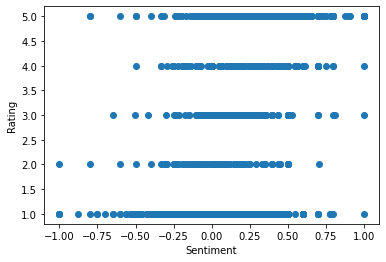

In [34]:
# See chart
import matplotlib.pyplot as plt
from importlib import reload

TOPIC_NAME = "fee"

plt = reload(plt)
x = reviews_df[reviews_df["topic"] == TOPIC_NAME]["sent_pol"] #! When you don't use loc you get a series
y = reviews_df[reviews_df["topic"] == TOPIC_NAME]["rating"]

plt.scatter(x, y)
plt.xlabel("Sentiment") #! dont do plt.xlabel = "sentiment"
plt.ylabel("Rating")


In [35]:
# Create the model and display fit
from sklearn import linear_model
model = linear_model.LinearRegression()
x = reviews_df.loc[reviews_df["topic"] == TOPIC_NAME].loc[:, ["sent_pol"]]
model.fit(x, y)
model.score(x, y)

0.1459908960194234

In [36]:
topic_dict = {
    "app" : "App/UI/Features",
    "fee" : "Fees",
    "transaction" : "Deposit/Withdrawals/Transaction Handling",
    "verification" : "Registration/Verification Process",
    "service" : "Customer Service",
    "trust" : "Trust and Company Reputation",
    "N": "Ignore this"
}

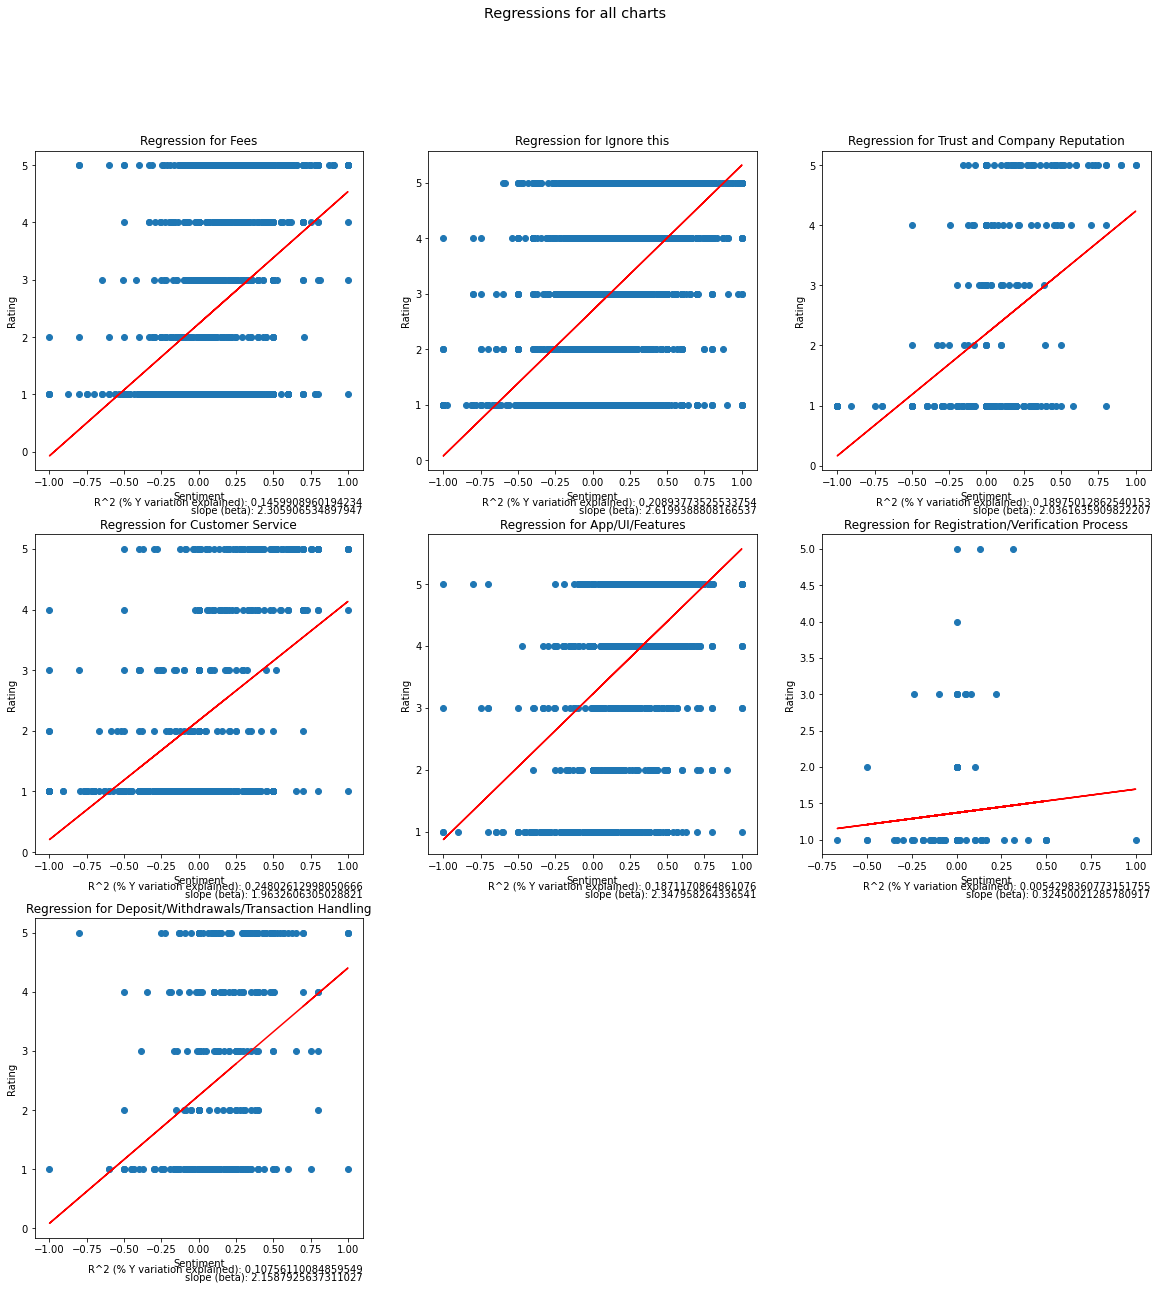

In [37]:
# Now we plot for all the topic
fig = plt.figure(figsize=(20,20))
st = fig.suptitle("Regressions for all charts", fontsize="x-large")

idx = 1
for key in reviews_df["topic"].unique():
    y = reviews_df[reviews_df["topic"] == key]["rating"]
    x = reviews_df.loc[reviews_df["topic"] == key].loc[:, ["sent_pol"]]
    model.fit(x, y)
    score = model.score(x, y)
    x = reviews_df[reviews_df["topic"] == key]["sent_pol"]
    curr_plot = fig.add_subplot(3, 3, idx)
    curr_plot.scatter(x, y)
    curr_plot.set_title(f"Regression for {topic_dict[key]}")
    curr_plot.set_xlabel("Sentiment") #! dont do plt.xlabel = "sentiment"
    curr_plot.set_ylabel("Rating")
    curr_plot.plot(x, model.coef_*x + model.intercept_, "r") 
    curr_plot.annotate(f"slope (beta): {model.coef_[0]}",
            xy = (1.0, -0.125),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)
    curr_plot.annotate(f"R^2 (% Y variation explained): {score}",
            xy = (1.0, -0.1),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)

    idx = idx + 1

fig.show()

In [38]:
reviews_df.to_csv("sent_normal_bow.csv")